# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

import random
from queue import PriorityQueue
from math import floor

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection([]))

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


## Segment structure

In [3]:
class Segment:
    def __init__(self, P, Q, ind):
        x = 0
        y = 1
        if (P[x] < Q[x]):
            self.startPoint = P
            self.endPoint   = Q
        else:
            self.startPoint = Q
            self.endPoint   = P
        self.value = self.startPoint[y]
        self.segmentInd = ind
    
    def updateValue(self, value):
        x = 0
        y = 1
        staX = self.startPoint[x]
        endX = self.endPoint[x]
        staY = self.startPoint[y]
        endY = self.endPoint[y]
        self.value = staY + (((endY - staY) / (endX - staX)) * (value - staX))
    
    def printRep(self):
        """
            Print uniform segment representation.
        """
        return [self.startPoint, self.endPoint]

## Red-Black Tree Implementation

In [4]:
# Red Black Tree implementation in Python 2.7
# Author: Algorithm Tutor
# Tutorial URL: https://algorithmtutor.com/Data-Structures/Tree/Red-Black-Trees/
"""
    Some of the implementation was changed to make structure able to be used in algorithm.
"""
import sys

# data structure that represents a node in the tree
class Node():
    def __init__(self, data):
        self.data = data  # holds the key
        self.parent = None #pointer to the parent
        self.left = None # pointer to left child
        self.right = None #pointer to right child
        self.color = 0 # 1 . Red, 0 . Black
        


# class RedBlackTree implements the operations in Red Black Tree
class RedBlackTree():
    def __init__(self):
        self.TNULL = Node(0)
        self.TNULL.color = 0
        self.TNULL.left = self.TNULL
        self.TNULL.right = self.TNULL
        self.root = self.TNULL

    # fix the rb tree modified by the delete operation
    def __fix_delete(self, x):
        while (x != self.root and x.color == 0):
            if (x == x.parent.left):
                s = x.parent.right
                if (s.color == 1):
                    # case 3.1
                    s.color = 0
                    x.parent.color = 1
                    self.left_rotate(x.parent)
                    s = x.parent.right

                if (s.left.color == 0 and s.right.color == 0):
                    # case 3.2
                    s.color = 1
                    x = x.parent
                else:
                    if (s.right.color == 0):
                        # case 3.3
                        s.left.color = 0
                        s.color = 1
                        self.right_rotate(s)
                        s = x.parent.right

                    # case 3.4
                    s.color = x.parent.color
                    x.parent.color = 0
                    s.right.color = 0
                    self.left_rotate(x.parent)
                    x = self.root
            else:
                s = x.parent.left
                if (s.color == 1):
                    # case 3.1
                    s.color = 0
                    x.parent.color = 1
                    self.right_rotate(x.parent)
                    s = x.parent.left

                if (s.left.color == 0 and s.right.color == 0):
                    # case 3.2
                    s.color = 1
                    x = x.parent
                else:
                    if (s.left.color == 0):
                        # case 3.3
                        s.right.color = 0
                        s.color = 1
                        self.left_rotate(s)
                        s = x.parent.left 

                    # case 3.4
                    s.color = x.parent.color
                    x.parent.color = 0
                    s.left.color = 0
                    self.right_rotate(x.parent)
                    x = self.root
        x.color = 0

    def __rb_transplant(self, u, v):
        if (u.parent == self.TNULL):
            self.root = v
        elif u == u.parent.left:
            u.parent.left = v
        else:
            u.parent.right = v
        v.parent = u.parent

    def __delete_node_helper(self, node):
        # find the node containing key
        z = node
        if (z == self.TNULL):
            return

        y = z
        y_original_color = y.color
        if (z.left == self.TNULL):
            x = z.right
            self.__rb_transplant(z, z.right)
        elif (z.right == self.TNULL):
            x = z.left
            self.__rb_transplant(z, z.left)
        else:
            y = self.minimum(z.right)
            y_original_color = y.color
            x = y.right
            if (y.parent == z):
                x.parent = y
            else:
                self.__rb_transplant(y, y.right)
                y.right = z.right
                y.right.parent = y

            self.__rb_transplant(z, y)
            y.left = z.left
            y.left.parent = y
            y.color = z.color
        if (y_original_color == 0):
            self.__fix_delete(x)
    
    # fix the red-black tree
    def  __fix_insert(self, k):
        while (k.parent.color == 1):
            if (k.parent == k.parent.parent.right):
                u = k.parent.parent.left # uncle
                if (u.color == 1):
                    # case 3.1
                    u.color = 0
                    k.parent.color = 0
                    k.parent.parent.color = 1
                    k = k.parent.parent
                else:
                    if (k == k.parent.left):
                        # case 3.2.2
                        k = k.parent
                        self.right_rotate(k)
                    # case 3.2.1
                    k.parent.color = 0
                    k.parent.parent.color = 1
                    self.left_rotate(k.parent.parent)
            else:
                u = k.parent.parent.right # uncle

                if (u.color == 1):
                    # mirror case 3.1
                    u.color = 0
                    k.parent.color = 0
                    k.parent.parent.color = 1
                    k = k.parent.parent 
                else:
                    if (k == k.parent.right):
                        # mirror case 3.2.2
                        k = k.parent
                        self.left_rotate(k)
                    # mirror case 3.2.1
                    k.parent.color = 0
                    k.parent.parent.color = 1
                    self.right_rotate(k.parent.parent)
            if (k == self.root):
                break
        self.root.color = 0

    def __print_helper(self, node, indent, last):
        # print the tree structure on the screen
        if (node != self.TNULL):
            sys.stdout.write(indent)
            if (last):
                sys.stdout.write("R----")
                indent += "     "
            else:
                sys.stdout.write("L----")
                indent += "|    "

            s_color = "RED" if node.color == 1 else "BLACK"
            print("label: " + str(node.data.segmentInd) + "  val: " + 
                  str(node.data.value) + "(" + str(s_color) + ")")
            self.__print_helper(node.left, indent, False)
            self.__print_helper(node.right, indent, True)
    
    # search the tree for the key k
    # and return the corresponding node
    def searchTree(self, key):
        x = self.root
        while (x != self.TNULL):
            if (key.value == x.data.value):
                return x
            elif(x.data.value > key.value):
                x = x.left
            else:
                x = x.right
        return x

    # find the node with the minimum key
    def minimum(self, node):
        while (node.left != self.TNULL):
            node = node.left
        return node

    # find the node with the maximum key
    def maximum(self, node):
        while (node.right != self.TNULL):
            node = node.right
        return node

    # find the successor of a given node
    def successor(self, x):
        # if the right subtree is not None,
        # the successor is the leftmost node in the
        # right subtree
        if (x.right != self.TNULL):
            return self.minimum(x.right)

        # else it is the lowest ancestor of x whose
        # left child is also an ancestor of x.
        y = x.parent
        while (y != self.TNULL and x == y.right):
            x = y
            y = y.parent
        return y

    # find the predecessor of a given node
    def predecessor(self,  x):
        # if the left subtree is not None,
        # the predecessor is the rightmost node in the 
        # left subtree
        if (x.left != self.TNULL):
            return self.maximum(x.left)

        y = x.parent
        while (y != self.TNULL and x == y.left):
            x = y
            y = y.parent

        return y

    # rotate left at node x
    def left_rotate(self, x):
        y = x.right
        x.right = y.left
        if (y.left != self.TNULL):
            y.left.parent = x

        y.parent = x.parent
        if (x.parent == self.TNULL):
            self.root = y
        elif (x == x.parent.left):
            x.parent.left = y
        else:
            x.parent.right = y
        y.left = x
        x.parent = y

    # rotate right at node x
    def right_rotate(self, x):
        y = x.left
        x.left = y.right
        if (y.right != self.TNULL):
            y.right.parent = x

        y.parent = x.parent
        if (x.parent == self.TNULL):
            self.root = y
        elif (x == x.parent.right):
            x.parent.right = y
        else:
            x.parent.left = y
        y.right = x
        x.parent = y

    # insert the key to the tree in its appropriate position
    # and fix the tree
    def insert(self, key):
        # Ordinary Binary Search Insertion
        node = Node(key)
        node.parent = self.TNULL
        node.data = key
        node.left = self.TNULL
        node.right = self.TNULL
        node.color = 1 # new node must be red

        y = self.TNULL
        x = self.root

        while (x != self.TNULL):
            y = x
            if (node.data.value < x.data.value):
                x = x.left
            else:
                x = x.right

        # y is parent of x
        node.parent = y
        if (y == self.TNULL):
            self.root = node
        elif (node.data.value < y.data.value):
            y.left = node
        else:
            y.right = node

        # if new node is a root node, simply return
        if (node.parent == self.TNULL):
            node.color = 0
            return

        # if the grandparent is None, simply return
        if (node.parent.parent == self.TNULL):
            return

        # Fix the tree
        self.__fix_insert(node)

    def recalculate(self, node, value):
        if (node != self.TNULL):
            node.data.updateValue(value)
            self.recalculate(node.left, value)
            self.recalculate(node.right, value)
        
    # delete the node from the tree
    def delete_node(self, node):
        self.__delete_node_helper(node)

    # return list of nodes generated by inorder traversal
    def inorder_nodes(self):
        L = []
        x = self.minimum(self.root)
        while (x != self.TNULL):
            L.append(x.data)
            x = self.successor(x)
        return L
    
    def inorder_print(self):
        L = self.inorder_nodes()
        print("\n")
        for i in range(len(L)):
            print("label: " + str(L[i].segmentInd) + " value: " + str(L[i].value))
        print("\n")
    
    # print the tree structure on the screen
    def pretty_print(self):
        self.__print_helper(self.root, "", True)

## Segments input

<IPython.core.display.Javascript object>


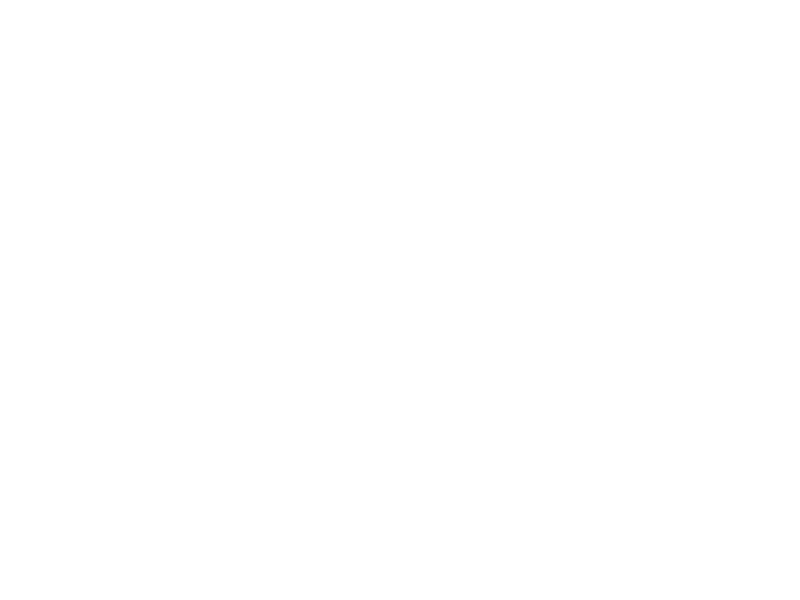

In [5]:
%matplotlib notebook

inputPlot = Plot()
inputPlot.draw()

### Visualization of segments and extraction of lines

Lines which cannot be handled by algorithm are removed

In [6]:
eps = 1e-12

In [7]:
def removeWrongSegments(lines):
    #remove vertical lines and make firs point of segment be the left one
    for line in lines:
        if (abs(line[0][0] - line[1][0]) < eps):
            lines.remove(line)
        if (line[0][0] > line[1][0]):
            line[0], line[1] = line[1], line[0]

    # remove lines having the same end
    for line1 in lines:
        for line2 in lines:
            if (line1 != line2):
                if ((abs(line1[0][0] - line2[0][0]) < eps and abs(line1[0][1] - line2[0][1]) < eps) or
                    (abs(line1[1][0] - line2[0][0]) < eps and abs(line1[1][1] - line2[0][1]) < eps) or
                    (abs(line1[0][0] - line2[1][0]) < eps and abs(line1[0][1] - line2[1][1]) < eps) or
                    (abs(line1[1][0] - line2[1][0]) < eps and abs(line1[1][1] - line2[1][1]) < eps)):
                    lines.remove(line1)
                    lines.remove(line2)
    
    return lines

<IPython.core.display.Javascript object>


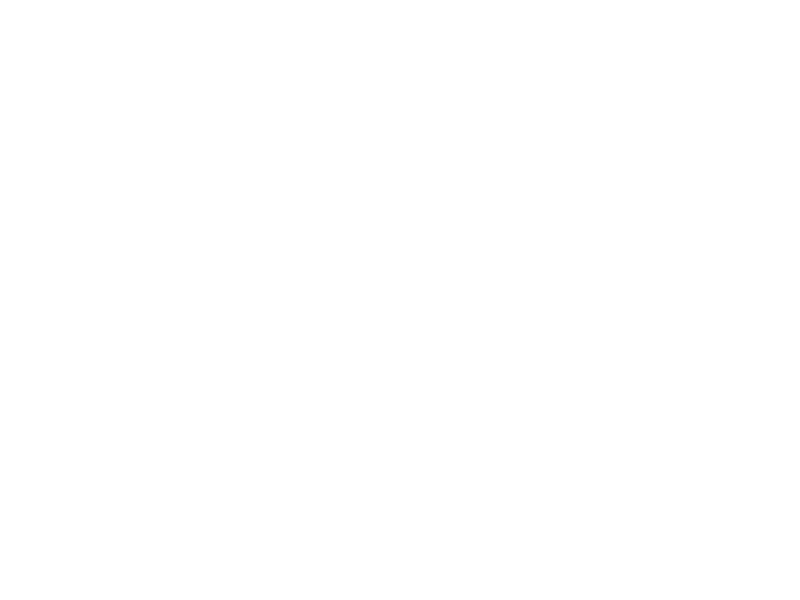

In [8]:
segmentsImported = []
if (len(inputPlot.get_added_lines()) > 0):
    segmentsImported = inputPlot.get_added_lines()[0].lines.copy()
    segmentImported = removeWrongSegments(segmentsImported)

plot = Plot([Scene(lines=[LinesCollection(segmentsImported)])])
plot.draw()

## Segments generation

In [9]:
def generateSegment(numberOfSegments, leftXBoundary, rightXBoundary, leftYBoundary, rightYBoundary):
    L = []
    
    for i in range(numberOfSegments):
        x1 = (rightXBoundary - leftXBoundary) * random.random() + leftXBoundary
        y1 = (rightYBoundary - leftYBoundary) * random.random() + leftYBoundary
        
        x2 = y2 = 0
        while (True):
            x2 = (rightXBoundary - leftXBoundary) * random.random() + leftXBoundary
            y2 = (rightYBoundary - leftYBoundary) * random.random() + leftYBoundary
            if (abs(y2 - y1) > eps and abs(x2 - x1) > eps):
                break
        L.append([(x1,y1), (x2,y2)])
        
    return L

In [10]:
'''
    Particular segments generation
'''
generatedSegments = generateSegment(7, 0, 10, -10, 10)
generatedSegments = removeWrongSegments(generatedSegments)

<IPython.core.display.Javascript object>


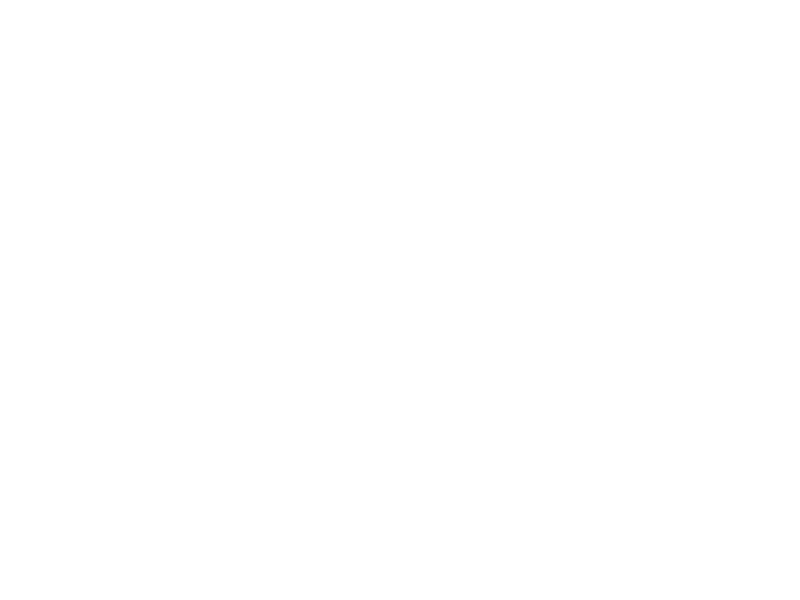

In [11]:
%matplotlib notebook
'''
    Visualization of segments generated above
'''

plot = Plot([Scene([], [LinesCollection(generatedSegments)])])
plot.draw()

## Segments intersection

In [12]:
def truncate(P, places):
    '''
        This function truncates points to choosen number of decimal places.
        It is necessary for avoiding duplicates of intersection points.
    '''
    x = 0
    y = 1

    return (floor(P[x] * (10**places)) / (10**places), floor(P[y] * (10**places)) / (10**places))

In [13]:
def segmentsCompare(seg1, seg2):
    x = 0
    y = 1
    A = seg1.startPoint
    C = seg2.startPoint
    
    if (A[y] == C[y]):
        if (A[x] == C[x]):
            return 0
        elif(A[x] > C[x]):
            return 1
        else:
            return (-1)
    elif(A[y] > C[y]):
        return 1
    else:
        return (-1)

In [14]:
def det(A, B, C):
    x = 0
    y = 1
    return (A[x] - C[x]) * (B[y] - C[y]) - (B[x] - C[x]) * (A[y] - C[y])

In [15]:
def onSegment(line, P):
    x = 0
    y = 1
    if (P[x] <= max(line.startPoint[x], line.endPoint[x]) and
            P[x] >= min(line.startPoint[x], line.endPoint[x]) and
            P[y] <= max(line.startPoint[y], line.endPoint[y]) and
            P[y] >= min(line.startPoint[y], line.endPoint[y])):
        return True
  
    return False 

In [16]:
def checkSegmentsIntersection(segment1, segment2):
    P1 = segment1.startPoint
    Q1 = segment1.endPoint
    P2 = segment2.startPoint
    Q2 = segment2.endPoint
    
    det1 = det(P1, Q1, P2)
    det2 = det(P1, Q1, Q2)
    det3 = det(P2, Q2, P1)
    det4 = det(P2, Q2, Q1)
    
    if (det1 * det2 < 0 and det3 * det4 < 0):
        return True
    
    if (abs(det1) == 0 and onSegment(segment1, Q1)):
        return True
  
    if (abs(det2) == 0 and onSegment(segment1, Q2)):
        return True
  
    if (abs(det3) == 0 and onSegment(segment2, P1)):
        return True
  
    if (abs(det4) == 0 and onSegment(segment2, Q1)):
        return True
    
    return False

In [17]:
def segmentsIntersection(segment1, segment2):
    if (checkSegmentsIntersection(segment1, segment2) == False):
        return False
    A = segment1.startPoint
    B = segment1.endPoint
    C = segment2.startPoint
    D = segment2.endPoint

    x = 0
    y = 1
    
    '''
        Find solution to system of equations:
        { t * A[x] + (1 - t) * B[x] = r * C[x] + (1 - r) * D[x]
        { t * A[y] + (1 - t) * B[y] = r * C[y] + (1 - r) * D[y]
        
        which is equivalent to:
        t(A-B) + r(D-C) = D-B
    '''
    
    W  = (A[x] - B[x]) * (D[y] - C[y]) - (D[x] - C[x]) * (A[y] - B[y])
    Wt = (D[x] - B[x]) * (D[y] - C[y]) - (D[x] - C[x]) * (D[y] - B[y])
    Wr = (A[x] - B[x]) * (D[y] - B[y]) - (D[x] - B[x]) * (A[y] - B[y])
    
    if (W == 0): return False
    t = Wt / W
    r = Wr / W
    return (t * A[x] + (1 - t) * B[x], t * A[y] + (1 - t) * B[y])

In [18]:
def doesSegmentSetIntersect(segmentsOriginal):
    Segments = [Segment(seg[0], seg[1], i) for i, seg in enumerate(segmentsOriginal)]
    T = RedBlackTree()
    pointSegment = {}
    
    Points = []
    for seg in Segments:
        Points.append(seg.startPoint)
        pointSegment[seg.startPoint] = seg
        Points.append(seg.endPoint)
        pointSegment[seg.endPoint] = seg
        
    Points.sort(key=lambda x: x[0])
    
    for P in Points:
        seg = pointSegment[P]
        
        # P is left end of the segment
        if (P == seg.startPoint):
            T.recalculate(T.root, P[0])
            T.insert(seg)
            node = T.searchTree(seg)
            pred = T.predecessor(node)
            succ = T.successor(node)
            if (pred != T.TNULL and checkSegmentsIntersection(seg, pred.data) == True):
                return True
            if (succ != T.TNULL and checkSegmentsIntersection(seg, succ.data) == True):
                return True
        # P is right end of the segment
        elif(P == seg.endPoint):
            node = T.searchTree(seg)
            pred = T.predecessor(node)
            succ = T.successor(node)
            if (pred != T.TNULL and succ != T.TNULL and
                    checkSegmentsIntersection(pred.data, succ.data) == True):
                return True
            T.delete_node(node)
        
    return False

#### Results of intersection test for generated lines and inserted ones.

In [19]:
print(doesSegmentSetIntersect(segmentsImported))

False


In [20]:
print(doesSegmentSetIntersect(generatedSegments))

True


## Intersection detecting visualization

In [21]:
def doesSegmentSetIntersectStepByStep(segmentsOriginal):
    if (len(segmentsOriginal) == 0): return False, [Scene()]
    Segments = [Segment(seg[0], seg[1], i) for i, seg in enumerate(segmentsOriginal)]
    T = RedBlackTree()
    pointSegment = {}
    segmentsToVisualize = [[seg.startPoint, seg.endPoint] for seg in Segments]
    IntersectionPoint = False
     
    x = 0
    y = 1   
    highestY = Segments[0].startPoint[y]
    lowestY  = Segments[0].startPoint[y]
    
    Q = []
    for seg in Segments:
        if (highestY < seg.startPoint[y]):
            highestY = seg.startPoint[y]
        if (highestY < seg.endPoint[y]):
            highestY = seg.endPoint[y]
        if (lowestY  > seg.startPoint[y]):
            lowestY  = seg.startPoint[y]
        if (lowestY  > seg.endPoint[y]):
            lowestY  = seg.endPoint[1]
        Q.append(seg.startPoint)
        pointSegment[seg.startPoint] = seg
        Q.append(seg.endPoint)
        pointSegment[seg.endPoint] = seg
        
    Q.sort(key=lambda x: x[0])
    
    plotRange = (highestY - lowestY) * 0.25
    
    sweepEndpoints = [(Q[0][x], lowestY - plotRange),  (Q[0][x], highestY + plotRange),
                      (Q[-1][x], lowestY - plotRange), (Q[-1][x], highestY + plotRange)]
    scenes = [Scene([PointsCollection(sweepEndpoints, color="white")],
                    [LinesCollection(segmentsToVisualize)])]
    finalSegments = []
    
    for P in Q:
        seg = pointSegment[P]
        
        sweep = [(P[x], lowestY - plotRange), (P[x], highestY + plotRange)]
        scenes.append(Scene(points=[PointsCollection(sweepEndpoints, color="white"),
                                    PointsCollection([P].copy())],
                            lines=[LinesCollection(segmentsToVisualize),
                                   LinesCollection([sweep].copy(), color="black")]))
            # P is left end of the segment
        if (P == seg.startPoint):
            T.recalculate(T.root, P[0])
            T.insert(seg)
            node = T.searchTree(seg)
            pred = T.predecessor(node)
            succ = T.successor(node)
            if (pred != T.TNULL):
                scenes.append(Scene(points=[PointsCollection(sweepEndpoints, color="white"),
                                            PointsCollection([P].copy())],
                                    lines=[LinesCollection(segmentsToVisualize),
                                           LinesCollection([sweep].copy(), color="black"),
                                           LinesCollection([pred.data.printRep(), seg.printRep()],
                                                           color="red")]))
                
                IntersectionPoint = segmentsIntersection(seg, pred.data)
                if (IntersectionPoint != False):
                    scenes.append(Scene(points=[PointsCollection(sweepEndpoints, color="white"),
                                                PointsCollection([P]),
                                                PointsCollection([IntersectionPoint], color="orange")],
                                        lines=[LinesCollection(segmentsToVisualize),
                                               LinesCollection([sweep].copy(), color="black"),
                                               LinesCollection([pred.data.printRep(), seg.printRep()],
                                                               color="red")]))
                    finalSegments.append(pred.data.printRep())
                    finalSegments.append(seg.printRep())
                    break
            if (succ != T.TNULL):
                scenes.append(Scene(points=[PointsCollection(sweepEndpoints, color="white"),
                                            PointsCollection([P])],
                                    lines=[LinesCollection(segmentsToVisualize),
                                           LinesCollection([sweep].copy(), color="black"),
                                           LinesCollection([seg.printRep(), succ.data.printRep()],
                                                           color="red")]))
                
                IntersectionPoint = segmentsIntersection(seg, succ.data)
                if (IntersectionPoint != False):
                    scenes.append(Scene(points=[PointsCollection(sweepEndpoints, color="white"),
                                                PointsCollection([P].copy()),
                                                PointsCollection([IntersectionPoint], color="orange")],
                                        lines=[LinesCollection(segmentsToVisualize),
                                               LinesCollection([sweep].copy(), color="black"),
                                               LinesCollection([seg.printRep(), succ.data.printRep()],
                                                               color="red")]))
                    finalSegments.append(succ.data.printRep())
                    finalSegments.append(seg.printRep())
                    break
            # P is right end of the segment
        elif(P == seg.endPoint):
            node = T.searchTree(seg)
            pred = T.predecessor(node)
            succ = T.successor(node)
            if (pred != T.TNULL and succ != T.TNULL):
                scenes.append(Scene(points=[PointsCollection(sweepEndpoints, color="white"),
                                            PointsCollection([P])],
                                    lines=[LinesCollection(segmentsToVisualize),
                                           LinesCollection([sweep].copy(), color="black"),
                                           LinesCollection([pred.data.printRep(), succ.data.printRep()],
                                                           color="red")]))
                
                IntersectionPoint = segmentsIntersection(pred.data, succ.data)
                if (IntersectionPoint != False):
                    scenes.append(Scene(points=[PointsCollection(sweepEndpoints, color="white"),
                                                PointsCollection([P]),
                                                PointsCollection([IntersectionPoint], color="orange")],
                                        lines=[LinesCollection(segmentsToVisualize),
                                               LinesCollection([sweep].copy(), color="black"),
                                               LinesCollection([pred.data.printRep(),
                                                                succ.data.printRep()],
                                                               color="red")]))
                    finalSegments.append(pred.data.printRep())
                    finalSegments.append(succ.data.printRep())
                    break
            T.delete_node(node)
            
    if (IntersectionPoint != False):
        scenes.append(Scene(points=[PointsCollection(sweepEndpoints, color="white"),
                                    PointsCollection([IntersectionPoint], color="purple")],
                            lines=[LinesCollection(segmentsToVisualize),
                                   LinesCollection(finalSegments, color="red")]))
    
    if (IntersectionPoint != False):
            return True, scenes
    return False, scenes

not found intersection


<IPython.core.display.Javascript object>


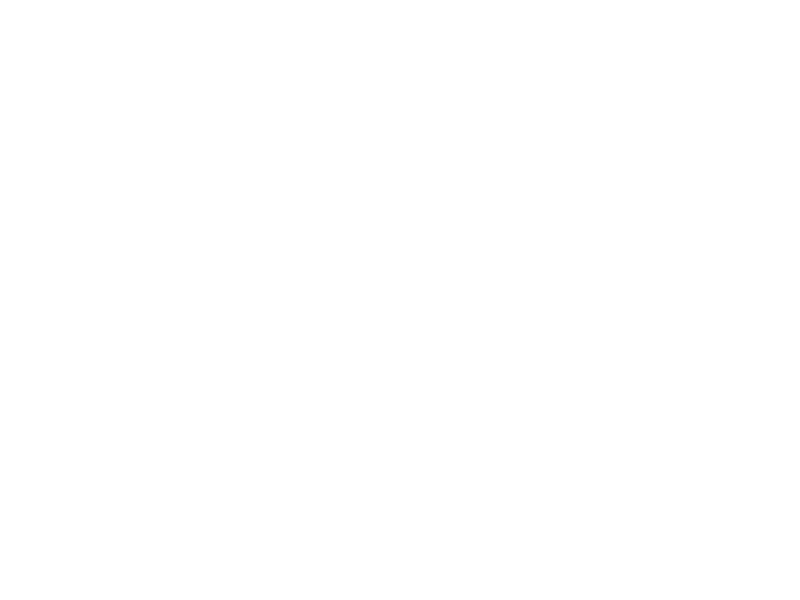

In [22]:
%matplotlib notebook

answerImport, scenesImport = doesSegmentSetIntersectStepByStep(segmentsImported)

print("found intersection" if answerImport else "not found intersection")

plot = Plot(scenesImport)
plot.draw()

found intersection


<IPython.core.display.Javascript object>


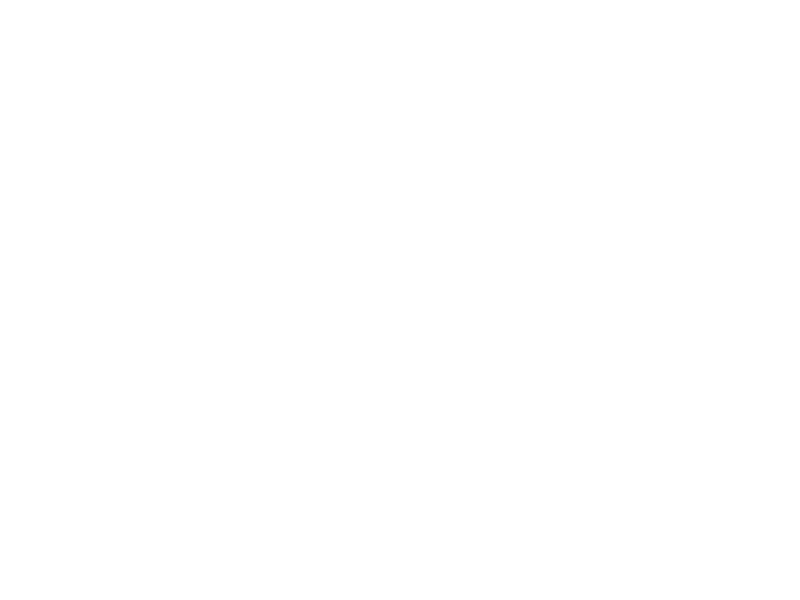

In [23]:
%matplotlib notebook
answerGen, scenesLines = doesSegmentSetIntersectStepByStep(generatedSegments)

print("found intersection" if answerGen else "not found intersection")

plot = Plot(scenesLines)
plot.draw()

# Bentley-Ottmann algorithm

In [24]:
def segmentsCompareSweep(seg1, seg2, Sweep):
    x = 0
    y = 1
    
    if (seg1 == seg2):
        return 0
    a1 = (seg1[1][y] - seg1[0][y]) / (seg1[1][x] - seg1[0][x])
    a2 = (seg2[1][y] - seg2[0][y]) / (seg2[1][x] - seg2[0][x])
    b1 = seg1[0][y] - a1 * seg1[0][x]
    b2 = seg2[0][y] - a2 * seg2[0][x]
    
    
    seg1Y = a1 * Sweep[0][x] + b1
    seg2Y = a2 * Sweep[0][x] + b2
    
    if (seg1Y - seg2Y > 0):
        return 1
    else:
        return (-1)

In [39]:
def BentleyOttmann(segmentsOriginal):
    
        # Make objects from segments and print their labeling
    Segments = [Segment(seg[0], seg[1], i) for i, seg in enumerate(segmentsOriginal)]
    for i, s in enumerate(Segments):
        print("label: " + str(i) + "  [" + str(s.startPoint) + ", " + str(s.endPoint) + "]")

        # event queue, it holds triplets (point, list of segments, type of the event)
    Q = PriorityQueue()
        # state of the sweep structure
    T = RedBlackTree()
    IntersectionPoints = []
        # number of decimal places which will stay after truncation
    trunc = 8
        # dictionary which has truncated points as keys
    pointInterSeg = {}
    x = 0
    y = 1
    
        # put segments endpoints on the event queue
    for seg in Segments:
        Q.put((seg.startPoint, [seg], "start"))
        Q.put((seg.endPoint, [seg], "end"))

    while (Q.empty() == False):
        P, segs, evType = Q.get()
    
    
            # for starting endpoint recalculate values for every segments in state structure,
            # then input segment to the state structure and check if the segment, whose one
            # of the endpoints is P, intersects with segments directly above and below it
        if (evType == "start"):
            T.recalculate(T.root, P[x])
            T.insert(segs[0])
            node = T.searchTree(segs[0])
            pred = T.predecessor(node)
            succ = T.successor(node)
                # check for intersection with segment below if there is one
            if (pred != T.TNULL):
                
                # The schema for checking intersection is as follows:
                # 1) There is intersection point assigned to pointInter 
                #    or false if segments does not intersect.
                # 2) If intersection point exists, it is truncated and
                #    assigned to pointInterTrunc variable.
                #    Otherwise false is assigned to this variable.
                # 3) If the intersection point exists(pointInter is not false),
                #    it is on the right (judging by x coordinate) from the current
                #    sweep position and it was not processed yet, then go to 4) 
                #    otherwise just omit the following step.
                # 4) Add new event to event queue and add point truncation to
                #    the dictionary of truncation.
                
                pointInter = segmentsIntersection(pred.data, segs[0])     # 1) 
                if (pointInter != False):
                    pointInterTrunc = truncate(pointInter, trunc)         # 2) 
                else:
                    pointInterTrunc = pointInter
                    
                if (pointInter != False and pointInter[x] > P[x] and
                        pointInterTrunc not in pointInterSeg):            # 3) 
                    pointInterSeg[pointInterTrunc] = (segs[0], pred.data) # 4) 
                    Q.put((pointInter, [pred.data, segs[0]], "inter"))
                
                # check for intersection with segment above if there is one
            if (succ != T.TNULL):
                pointInter = segmentsIntersection(segs[0], succ.data)
                if (pointInter != False):
                    pointInterTrunc = truncate(pointInter, trunc)
                if (pointInter != False and pointInter[x] > P[x] and
                        pointInterTrunc not in pointInterSeg):
                    pointInterSeg[pointInterTrunc] = (segs[0], succ.data)
                    Q.put((pointInter, [succ.data, segs[0]], "inter"))   
                    
                    
            # for ending endpoint check if segment directly above and below intersect
            # each other, then delete segment, whose one of the endpoints is P,
            # from state structure
        elif (evType == "end"):
            node = T.searchTree(segs[0])
            pred = T.predecessor(node)
            succ = T.successor(node)
                # check for intersection of segment above and segment below
            if (succ != T.TNULL and pred != T.TNULL):
                pointInter = segmentsIntersection(pred.data, succ.data)
                if (pointInter != False):
                    pointInterTrunc = truncate(pointInter, trunc)
                else:
                    pointInterTrunc = pointInter
                if (pointInter != False and pointInter[x] > P[x] and
                        pointInterTrunc not in pointInterSeg):
                    pointInterSeg[pointInterTrunc] = (pred.data, succ.data)
                    Q.put((pointInter, [pred.data, succ.data], "inter"))
            T.delete_node(node)
            
            
            # for intersection point swap segments whose intersection point is
            # currently processed, then check if segment above intersects with
            # upper segment and segment below intersects with lower segment
            # also add current event point to the list of intersections
        else:
            seg1 = segs[0]
            seg2 = segs[1]
                # add point to the list of intersection points
            IntersectionPoints.append((P, [seg1, seg2]))
            
                # make swap in state structure
            node1 = T.searchTree(seg1)
            node2 = T.searchTree(seg2)
            T.delete_node(node1);
            T.delete_node(node2);
            value = seg1.value;
            seg1.value = seg2.value
            seg2.value = value
            T.insert(seg1)
            T.insert(seg2)
            node1 = T.searchTree(seg1)
            node2 = T.searchTree(seg2)
            
                # seg1 is the upper segment and seg2 is the lower one
            if (seg1.value > seg2.value):
                succ = T.successor(node1)
                pred = T.predecessor(node2)
                    #check if upper segment intersect with the one above
                if (succ != T.TNULL):
                    pointInter = segmentsIntersection(seg1, succ.data)
                    if (pointInter != False):
                        pointInterTrunc = truncate(pointInter, trunc)
                    else:
                        pointInterTrunc = False
                    if (pointInter != False and pointInter[x] > P[x] and
                            pointInterTrunc not in pointInterSeg):
                        pointInterSeg[pointInterTrunc] = (seg1, succ.data)
                        Q.put((pointInter, [seg1, succ.data], "inter"))
                        
                    #check if lower segment intersect with the one below
                if(pred != T.TNULL):
                    pointInter = segmentsIntersection(pred.data, seg2)
                    if (pointInter != False):
                        pointInterTrunc = truncate(pointInter, trunc)
                    else:
                        pointInterTrunc = False
                    if (pointInter != False and pointInter[x] > P[x] and
                            pointInterTrunc not in pointInterSeg):
                        pointInterSeg[pointInterTrunc] = (pred.data, seg2)
                        Q.put((pointInter, [pred.data, seg2], "inter"))
                        
                # seg2 is the upper segment and seg1 is the lower one
            else:
                succ = T.successor(node2)
                pred = T.predecessor(node1)
                
                    #check if upper segment intersect with the one above
                if (succ != T.TNULL):
                    pointInter = segmentsIntersection(seg2, succ.data)
                    if (pointInter != False):
                        pointInterTrunc = truncate(pointInter, trunc)
                    else:
                        pointInterTrunc = False
                    if (pointInter != False and pointInter[x] > P[x] and
                            pointInterTrunc not in pointInterSeg):
                        pointInterSeg[pointInterTrunc] = (seg2, succ.data)
                        Q.put((pointInter, [seg2, succ.data], "inter"))
                        
                    #check if lower segment intersect with the one below
                if(pred != T.TNULL):
                    pointInter = segmentsIntersection(pred.data, seg1)
                    if (pointInter != False):
                        pointInterTrunc = truncate(pointInter, trunc)
                    else:
                        pointInterTrunc = False
                    if (pointInter != False and pointInter[x] > P[x] and
                            pointInterTrunc not in pointInterSeg):
                        pointInterSeg[pointInterTrunc] = (pred.data, seg1)
                        Q.put((pointInter, [pred.data, seg1], "inter"))
            
    return IntersectionPoints

## Algorithm tests

### Tests without visualization

In [40]:
Intersections = BentleyOttmann(segmentsImported)

print("Number of intersections: " + str(len(Intersections)) + "\n")

if (len(Intersections) == 0):
    print("No intersections")
else:    
    for P in Intersections:
        print("Point: " + str(P[0]))
        print("First line label:  " + str(P[1][0].segmentInd))
        print("Second line label: " + str(P[1][1].segmentInd))

Number of intersections: 0

No intersections


In [41]:
Intersections = BentleyOttmann(generatedSegments)

print("Number of intersections: " + str(len(Intersections)) + "\n")

if (len(Intersections) == 0):
    print("No intersections")
else:    
    for P in Intersections:
        print("Point: " + str(P[0]))
        print("First line label:  " + str(P[1][0].segmentInd))
        print("Second line label: " + str(P[1][1].segmentInd))

label: 0  [(0.06235277043856957, -4.563750245223046), (9.796693184122397, 7.9557169816310065)]
label: 1  [(4.222022845421629, -2.6537156099717567), (9.682365916813215, 6.901408649959031)]
label: 2  [(3.949265934410552, -3.49827512672527), (8.98661615184796, -2.205415954101144)]
label: 3  [(3.4896691792623438, 8.179979342963144), (3.870690307608683, -3.7455027413316255)]
label: 4  [(4.076396150843962, 5.366437548372636), (6.778761979867979, -6.703037097284275)]
label: 5  [(6.861176666230616, -4.830886724642671), (8.959820694532844, 2.214435950434062)]
label: 6  [(1.149981498790077, 7.885844676448855), (5.763061207073305, 2.6844425464867268)]
Number of intersections: 8

Point: (3.5868549117794273, 5.138188151457227)
First line label:  6
Second line label: 3
Point: (3.7454877571520795, 0.17317961326227982)
First line label:  0
Second line label: 3
Point: (4.310084965650472, 4.322722002909482)
First line label:  6
Second line label: 4
Point: (4.905214063509129, 1.664719344515936)
First lin

In [42]:
test3 = [[(18.632999,-0.456000), (-17.973000,29.846001)],
        [(10.711000,-49.713001), (44.897999,10.854000)],
        [(4.558000,-24.339001), (40.367001,-12.191000)],
        [(-13.885000,20.887000), (-22.125000,15.871000)],
        [(25.216999,-22.073000), (14.402000,-24.028999)],
        [(-11.601000,48.555000), (-6.603000,-42.967999)],
        [(42.063999,-35.520000), (36.016998,21.103001)],
         [(48.861000,-14.015000), (-0.831000,3.419000)],
        [(-31.225000,1.808000), (44.335999,5.011000)],
        [(16.204000,-20.398001), (39.001999,7.774000)],
        [(21.882000,3.404000), (33.744999,-39.719002)],
        [(1.959000,-6.506000), (-16.334999,-17.238001)],
        [(-14.729000,-13.104000), (7.925000,-6.312000)],
        [(1.376000,10.294000), (-35.209000,0.238000)],
        [(46.278999,13.960000), (-29.990999,24.277000)],
        [(-30.150999,-6.058000), (-45.257999,-11.376000)],
        [(45.750000,49.078999), (-40.013000,11.954000)],
        [(2.393000,-30.174999), (-22.804001,-29.296000)]]


removeWrongSegments(test3)

Intersections = BentleyOttmann(test3)

print("Number of intersections: " + str(len(Intersections)) + "\n")

if (len(Intersections) == 0):
    print("No intersections")
else:    
    for P in Intersections:
        print("Point: " + str(P[0]))
        print("First line label:  " + str(P[1][0].segmentInd))
        print("Second line label: " + str(P[1][1].segmentInd))

label: 0  [(-17.973, 29.846001), (18.632999, -0.456)]
label: 1  [(10.711, -49.713001), (44.897999, 10.854)]
label: 2  [(4.558, -24.339001), (40.367001, -12.191)]
label: 3  [(-22.125, 15.871), (-13.885, 20.887)]
label: 4  [(14.402, -24.028999), (25.216999, -22.073)]
label: 5  [(-11.601, 48.555), (-6.603, -42.967999)]
label: 6  [(36.016998, 21.103001), (42.063999, -35.52)]
label: 7  [(-0.831, 3.419), (48.861, -14.015)]
label: 8  [(-31.225, 1.808), (44.335999, 5.011)]
label: 9  [(16.204, -20.398001), (39.001999, 7.774)]
label: 10  [(21.882, 3.404), (33.744999, -39.719002)]
label: 11  [(-16.334999, -17.238001), (1.959, -6.506)]
label: 12  [(-14.729, -13.104), (7.925, -6.312)]
label: 13  [(-35.209, 0.238), (1.376, 10.294)]
label: 14  [(-29.990999, 24.277), (46.278999, 13.96)]
label: 15  [(-45.257999, -11.376), (-30.150999, -6.058)]
label: 16  [(-40.013, 11.954), (45.75, 49.078999)]
label: 17  [(-22.804001, -29.296), (2.393, -30.174999)]
Number of intersections: 31

Point: (-29.1820858388228

### Algorithm with visualization

In [29]:
def changeSweepPos(sweep, P):
        sweep[0] = (P[0], sweep[0][1])
        sweep[1] = (P[0], sweep[1][1])

In [45]:
def BentleyOttmannStepByStep(segmentsOriginal):
    """
        I put visualization part in comments cover looking like that:
        #----------##----------##----------##----------##----------##----------##----------#   
        Some visualization code :)
        #----------##----------##----------##----------##----------##----------##----------#   
    """
    if (len(segmentsOriginal) == 0): return [], [Scene()]
    Segments = [Segment(seg[0], seg[1], i) for i, seg in enumerate(segmentsOriginal)]
    Q = PriorityQueue()
    T = RedBlackTree()
    IntersectionPoints = []
    IntersectionPointsToViz = []
    queueViz = []
    segmentsToVisualize = [seg.printRep() for seg in Segments]
    pointInterSeg = {}
    scenes = []
    trunc = 8
    x = 0
    y = 1

    highestY = Segments[0].startPoint[y]
    lowestY  = Segments[0].startPoint[y]
    lowestX  = Segments[0].startPoint[x]
    
    for seg in Segments:
        if (highestY < seg.startPoint[y]):
            highestY = seg.startPoint[y]
        if (highestY < seg.endPoint[y]):
            highestY = seg.endPoint[y]
        if (lowestY  > seg.startPoint[y]):
            lowestY  = seg.startPoint[y]
        if (lowestY  > seg.endPoint[y]):
            lowestY  = seg.endPoint[y]
        if (lowestX  > seg.startPoint[x]):
            lowestX  = seg.startPoint[x]
        if (lowestX  > seg.endPoint[x]):
            lowestX  = seg.endPoint[x]
        Q.put((seg.startPoint, [seg], "start"))
        Q.put((seg.endPoint, [seg], "end"))
        queueViz.append(seg.startPoint)
        queueViz.append(seg.endPoint)

    plotRange = (highestY - lowestY) * 0.25
    sweep = [(lowestX, lowestY - plotRange), (lowestX, highestY + plotRange)]
    #----------##----------##----------##----------##----------##----------##----------#   
    scenes.append(Scene(points=[PointsCollection(sweep, color="white")],
                        lines=[LinesCollection(segmentsToVisualize)]))
    #----------##----------##----------##----------##----------##----------##----------#   
    #----------##----------##----------##----------##----------##----------##----------#   
    scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                PointsCollection(sweep, color="white")],
                        lines=[LinesCollection(segmentsToVisualize)]))
    #----------##----------##----------##----------##----------##----------##----------#   
    
    while (Q.empty() == False):
        P, segs, evType = Q.get()
        
        if (evType == "inter"):
            IntersectionPoints.append((P, [segs[0].printRep(), segs[1].printRep()]))
            IntersectionPointsToViz.append(P)
    
        changeSweepPos(sweep, P)
        sweepPos = [sweep.copy()]
    
        #----------##----------##----------##----------##----------##----------##----------##----------#
        scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                    PointsCollection(IntersectionPointsToViz.copy(), color="purple"),
                                    PointsCollection([P], color="black")],
                            lines=[LinesCollection(segmentsToVisualize),
                                   LinesCollection(sweepPos.copy(), color="black")]))
        #----------##----------##----------##----------##----------##----------##----------##----------#
    
        if (evType == "start"):
            T.recalculate(T.root, P[x])
            T.insert(segs[0])
            node = T.searchTree(segs[0])
            pred = T.predecessor(node)
            succ = T.successor(node)
            if (pred != T.TNULL):
                pointInter = segmentsIntersection(pred.data, segs[0])
                #----------##----------##----------##----------##----------##----------##----------#   
                scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                            PointsCollection(IntersectionPointsToViz.copy(),
                                                             color="purple"),
                                            PointsCollection([P], color="black")],
                                    lines=[LinesCollection(segmentsToVisualize.copy()),
                                           LinesCollection(sweepPos.copy(), color="black"),
                                           LinesCollection([pred.data.printRep(), segs[0].printRep()],
                                                           color="red")]))
                #----------##----------##----------##----------##----------##----------##----------#
                if (pointInter != False):
                    pointInterTrunc = truncate(pointInter, trunc)
                else:
                    pointInterTrunc = pointInter
                if (pointInter != False and pointInter[x] > P[x] and
                        pointInterTrunc not in pointInterSeg):
                    #----------##----------##----------##----------##----------##----------##----------#   
                    scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                PointsCollection(IntersectionPointsToViz.copy(),
                                                                 color="purple"),
                                                PointsCollection([pointInter], color="orange"),
                                                PointsCollection([P], color="black")],
                                        lines=[LinesCollection(segmentsToVisualize.copy()),
                                               LinesCollection(sweepPos.copy(), color="black"),
                                               LinesCollection([pred.data.printRep(), segs[0].printRep()],
                                                               color="red")]))
                    #----------##----------##----------##----------##----------##----------##----------#
                    pointInterSeg[pointInterTrunc] = (segs[0], pred.data)
                    Q.put((pointInter, [pred.data, segs[0]], "inter"))
                    queueViz.append(pointInter)
                    
            if (succ != T.TNULL):
                pointInter = segmentsIntersection(segs[0], succ.data)
                #----------##----------##----------##----------##----------##----------##----------#   
                scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                            PointsCollection(IntersectionPointsToViz.copy(),
                                                             color="purple"),
                                            PointsCollection([P], color="black")],
                                    lines=[LinesCollection(segmentsToVisualize.copy()),
                                           LinesCollection(sweepPos.copy(), color="black"),
                                           LinesCollection([segs[0].printRep(), succ.data.printRep()],
                                                           color="red")]))
                #----------##----------##----------##----------##----------##----------##----------#
                if (pointInter != False):
                    pointInterTrunc = truncate(pointInter, trunc)
                if (pointInter != False and pointInter[x] > P[x] and
                        pointInterTrunc not in pointInterSeg):
                    #----------##----------##----------##----------##----------##----------##----------#   
                    scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                PointsCollection(IntersectionPointsToViz.copy(),
                                                                 color="purple"),
                                                PointsCollection([pointInter], color="orange"),
                                                PointsCollection([P], color="black")],
                                        lines=[LinesCollection(segmentsToVisualize.copy()),
                                               LinesCollection(sweepPos.copy(), color="black"),
                                               LinesCollection([segs[0].printRep(), succ.data.printRep()],
                                                               color="red")]))
                    #----------##----------##----------##----------##----------##----------##----------#
                    pointInterSeg[pointInterTrunc] = (segs[0], succ.data)
                    Q.put((pointInter, [succ.data, segs[0]], "inter"))
                    queueViz.append(pointInter)
                    
        elif (evType == "end"):
            node = T.searchTree(segs[0])
            pred = T.predecessor(node)
            succ = T.successor(node)
            if (succ != T.TNULL and pred != T.TNULL):
                pointInter = segmentsIntersection(pred.data, succ.data)
                #----------##----------##----------##----------##----------##----------##----------#   
                scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                            PointsCollection(IntersectionPointsToViz.copy(),
                                                             color="purple"),
                                            PointsCollection([P], color="black")],
                                    lines=[LinesCollection(segmentsToVisualize.copy()),
                                           LinesCollection(sweepPos.copy(), color="black"),
                                           LinesCollection([pred.data.printRep(), succ.data.printRep()],
                                                           color="red")]))
                #----------##----------##----------##----------##----------##----------##----------#
                if (pointInter != False):
                    pointInterTrunc = truncate(pointInter, trunc)
                else:
                    pointInterTrunc = pointInter
                if (pointInter != False and pointInter[x] > P[x] and
                    pointInterTrunc not in pointInterSeg):
                    #----------##----------##----------##----------##----------##----------##----------#   
                    scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                PointsCollection(IntersectionPointsToViz.copy(),
                                                                 color="purple"),
                                                PointsCollection([pointInter], color="orange"),
                                                PointsCollection([P], color="black")],
                                        lines=[LinesCollection(segmentsToVisualize.copy()),
                                               LinesCollection(sweepPos.copy(), color="black"),
                                               LinesCollection([pred.data.printRep(), succ.data.printRep()],
                                                               color="red")]))
                    #----------##----------##----------##----------##----------##----------##----------#
                    pointInterSeg[pointInterTrunc] = (pred.data, succ.data)
                    Q.put((pointInter, [pred.data, succ.data], "inter"))
                    queueViz.append(pointInter)
            T.delete_node(node)
            
        else:
            seg1 = segs[0]
            seg2 = segs[1]
            node1 = T.searchTree(seg1)
            node2 = T.searchTree(seg2)
            T.delete_node(node1);
            T.delete_node(node2);
            value = seg1.value;
            seg1.value = seg2.value
            seg2.value = value
            T.insert(seg1)
            T.insert(seg2)
            node1 = T.searchTree(seg1)
            node2 = T.searchTree(seg2)
            
            if (seg1.value > seg2.value):
                succ = T.successor(node1)
                pred = T.predecessor(node2)
                if (succ != T.TNULL):
                    pointInter = segmentsIntersection(seg1, succ.data)
                    #----------##----------##----------##----------##----------##----------##----------#   
                    scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                PointsCollection(IntersectionPointsToViz.copy(),
                                                                 color="purple"),
                                                PointsCollection([P], color="black")],
                                        lines=[LinesCollection(segmentsToVisualize.copy()),
                                               LinesCollection(sweepPos.copy(), color="black"),
                                               LinesCollection([seg1.printRep(), succ.data.printRep()],
                                                               color="red")]))
                    #----------##----------##----------##----------##----------##----------##----------#
                    if (pointInter != False):
                        pointInterTrunc = truncate(pointInter, trunc)
                    else:
                        pointInterTrunc = False
                    if (pointInter != False and pointInter[x] > P[x] and
                        pointInterTrunc not in pointInterSeg):
                        #----------##----------##----------##----------##----------##----------##----------#   
                        scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                    PointsCollection(IntersectionPointsToViz.copy(),
                                                                     color="purple"),
                                                    PointsCollection([pointInter], color="orange"),
                                                    PointsCollection([P], color="black")],
                                            lines=[LinesCollection(segmentsToVisualize.copy()),
                                                   LinesCollection(sweepPos.copy(), color="black"),
                                                   LinesCollection([seg1.printRep(), succ.data.printRep()],
                                                                   color="red")]))
                        #----------##----------##----------##----------##----------##----------##----------#
                        pointInterSeg[pointInterTrunc] = (seg1, succ.data)
                        Q.put((pointInter, [seg1, succ.data], "inter"))
                        queueViz.append(pointInter)
                    
                if(pred != T.TNULL):
                    pointInter = segmentsIntersection(pred.data, seg2)
                    #----------##----------##----------##----------##----------##----------##----------#   
                    scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                PointsCollection(IntersectionPointsToViz.copy(),
                                                                 color="purple"),
                                                PointsCollection([P], color="black")],
                                        lines=[LinesCollection(segmentsToVisualize.copy()),
                                               LinesCollection(sweepPos.copy(), color="black"),
                                               LinesCollection([pred.data.printRep(), seg2.printRep()],
                                                               color="red")]))
                    #----------##----------##----------##----------##----------##----------##----------#
                    if (pointInter != False):
                        pointInterTrunc = truncate(pointInter, trunc)
                    else:
                        pointInterTrunc = False
                    if (pointInter != False and pointInter[x] > P[x] and
                        pointInterTrunc not in pointInterSeg):
                        #----------##----------##----------##----------##----------##----------##----------#   
                        scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                    PointsCollection(IntersectionPointsToViz.copy(),
                                                                     color="purple"),
                                                    PointsCollection([pointInter], color="orange"),
                                                    PointsCollection([P], color="black")],
                                            lines=[LinesCollection(segmentsToVisualize.copy()),
                                                   LinesCollection(sweepPos.copy(), color="black"),
                                                   LinesCollection([pred.data.printRep(), seg2.printRep()],
                                                                   color="red")]))
                        #----------##----------##----------##----------##----------##----------##----------#
                        pointInterSeg[pointInterTrunc] = (pred.data, seg2)
                        Q.put((pointInter, [pred.data, seg2], "inter"))
                        queueViz.append(pointInter)
            else:
                succ = T.successor(node2)
                pred = T.predecessor(node1)
                if (succ != T.TNULL):
                    pointInter = segmentsIntersection(seg2, succ.data)
                    #----------##----------##----------##----------##----------##----------##----------#   
                    scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                PointsCollection(IntersectionPointsToViz.copy(),
                                                                 color="purple"),
                                                PointsCollection([P], color="black")],
                                        lines=[LinesCollection(segmentsToVisualize.copy()),
                                               LinesCollection(sweepPos.copy(), color="black"),
                                               LinesCollection([seg2.printRep(), succ.data.printRep()],
                                                               color="red")]))
                    #----------##----------##----------##----------##----------##----------##----------#
                    if (pointInter != False):
                        pointInterTrunc = truncate(pointInter, trunc)
                    else:
                        pointInterTrunc = False
                    if (pointInter != False and pointInter[x] > P[x] and
                        pointInterTrunc not in pointInterSeg):
                        #----------##----------##----------##----------##----------##----------##----------#   
                        scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                    PointsCollection(IntersectionPointsToViz.copy(),
                                                                     color="purple"),
                                                    PointsCollection([pointInter], color="orange"),
                                                    PointsCollection([P], color="black")],
                                            lines=[LinesCollection(segmentsToVisualize.copy()),
                                                   LinesCollection(sweepPos.copy(), color="black"),
                                                   LinesCollection([seg2.printRep(), succ.data.printRep()],
                                                                   color="red")]))
                        #----------##----------##----------##----------##----------##----------##----------#
                        pointInterSeg[pointInterTrunc] = (seg2, succ.data)
                        Q.put((pointInter, [seg2, succ.data], "inter"))
                        queueViz.append(pointInter)
                    
                if(pred != T.TNULL):
                    pointInter = segmentsIntersection(pred.data, seg1)
                    #----------##----------##----------##----------##----------##----------##----------#   
                    scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                PointsCollection(IntersectionPointsToViz.copy(),
                                                                 color="purple"),
                                                PointsCollection([P], color="black")],
                                        lines=[LinesCollection(segmentsToVisualize.copy()),
                                               LinesCollection(sweepPos.copy(), color="black"),
                                               LinesCollection([pred.data.printRep(), seg1.printRep()],
                                                               color="red")]))
                    #----------##----------##----------##----------##----------##----------##----------#
                    if (pointInter != False):
                        pointInterTrunc = truncate(pointInter, trunc)
                    else:
                        pointInterTrunc = False
                    if (pointInter != False and pointInter[x] > P[x] and
                        pointInterTrunc not in pointInterSeg):
                        #----------##----------##----------##----------##----------##----------##----------#   
                        scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                                    PointsCollection(IntersectionPointsToViz.copy(),
                                                                     color="purple"),
                                                    PointsCollection([pointInter], color="orange"),
                                                    PointsCollection([P], color="black")],
                                            lines=[LinesCollection(segmentsToVisualize.copy()),
                                                   LinesCollection(sweepPos.copy(), color="black"),
                                                   LinesCollection([pred.data.printRep(), seg1.printRep()],
                                                                   color="red")]))
                        #----------##----------##----------##----------##----------##----------##----------#
                        pointInterSeg[pointInterTrunc] = (pred.data, seg1)
                        Q.put((pointInter, [pred.data, seg1], "inter"))
                        queueViz.append(pointInter)
        scenes.append(Scene(points=[PointsCollection(queueViz.copy()),
                                    PointsCollection(IntersectionPointsToViz.copy(), color="purple"),
                                    PointsCollection([P], color="black")],
                            lines=[LinesCollection(segmentsToVisualize.copy()),
                                   LinesCollection(sweepPos.copy(), color="black")]))

    #----------##----------##----------##----------##----------##----------##----------##----------#
    scenes.append(Scene(points=[PointsCollection(IntersectionPointsToViz.copy(), color="purple")],
                        lines=[LinesCollection(segmentsToVisualize),
                                LinesCollection(sweepPos.copy(), color="white")]))
    #----------##----------##----------##----------##----------##----------##----------##----------#
            
    return IntersectionPoints, scenes

### Visualization for segments from input

Number of intersection points: 0


<IPython.core.display.Javascript object>


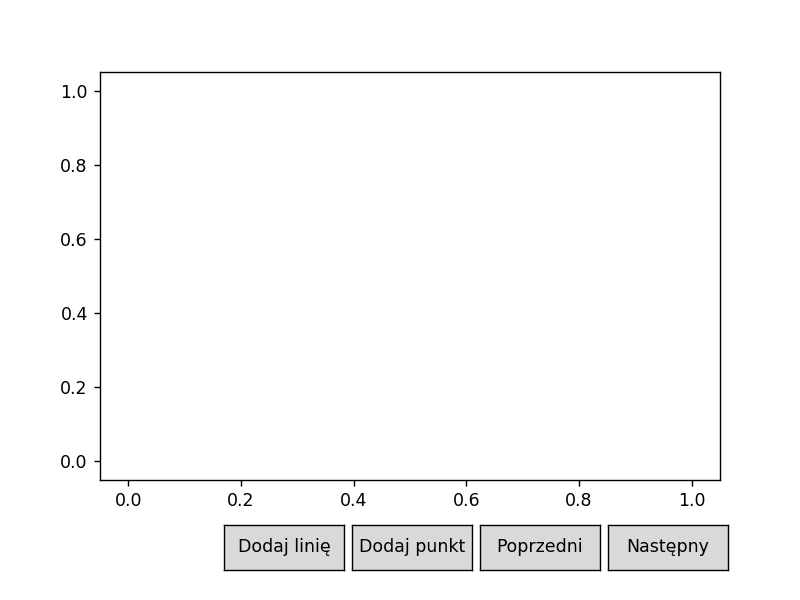

In [37]:
%matplotlib notebook
interPointsImport, scenesSeg = BentleyOttmannStepByStep(segmentsImported)

print("Number of intersection points: " + str(len(interPointsImport)))

plot = Plot(scenesSeg)
plot.draw()

Number of intersection points: 8


<IPython.core.display.Javascript object>


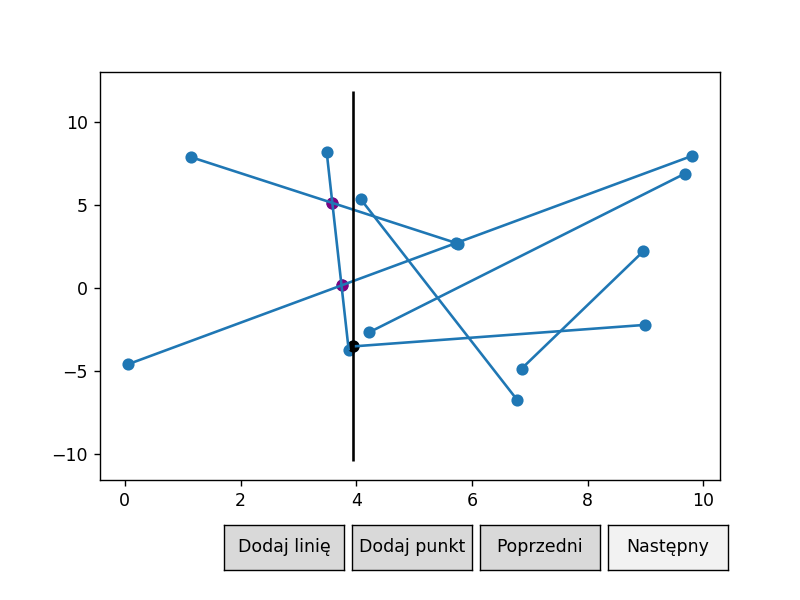

In [38]:
%matplotlib notebook

interPointsGen, scenesGen = BentleyOttmannStepByStep(generatedSegments)

print("Number of intersection points: " + str(len(interPointsGen)))

plot = Plot(scenesGen)
plot.draw()

Number of intersection points: 3


<IPython.core.display.Javascript object>


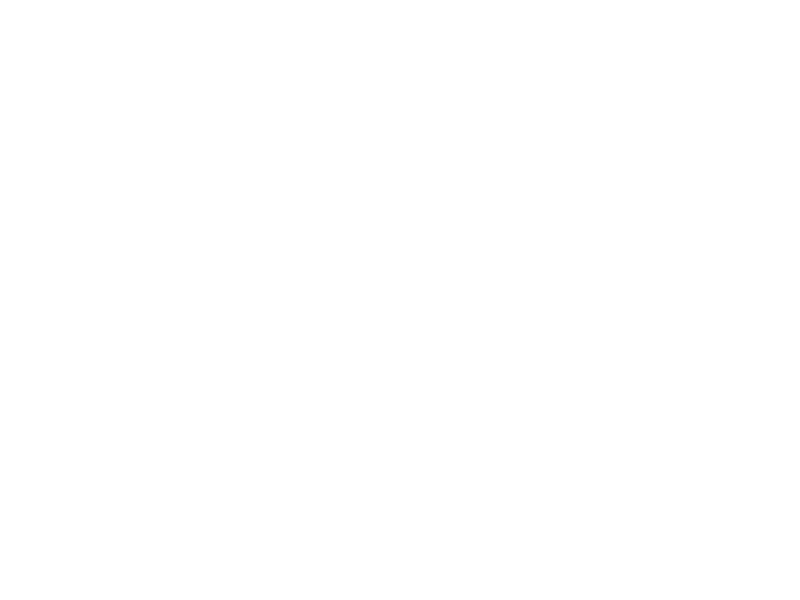

In [33]:
test1 = [[(0,0), (10,0)],
         [(0,10), (10,-10)],
         [(1,-10), (10,10)]]

intersections, scenes = BentleyOttmannStepByStep(test1)

print("Number of intersection points: " + str(len(intersections)))

plot = Plot(scenes)
plot.draw()

Number of intersection points: 1


<IPython.core.display.Javascript object>


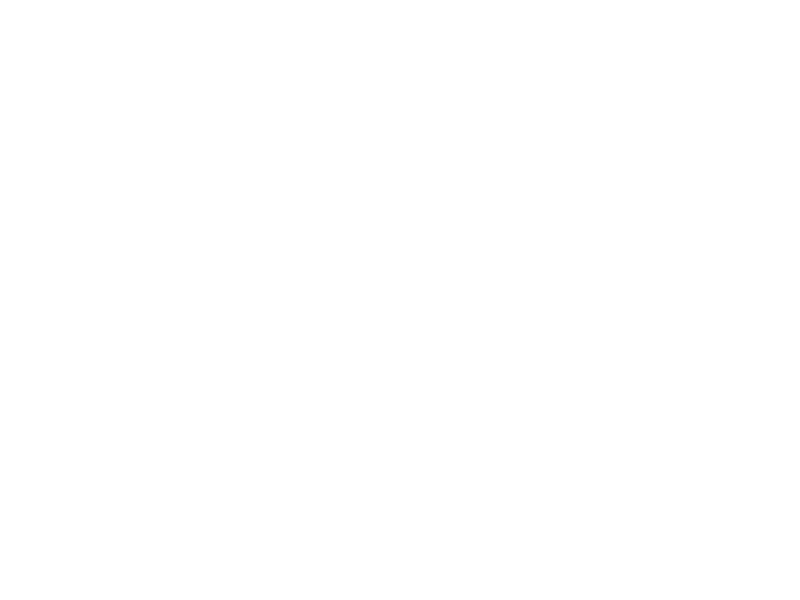

In [34]:
test2 = [[(0,0), (10,0)],
         [(0,10), (10,-10)],
         [(0,-10), (10,10)]]

intersections, scenes = BentleyOttmannStepByStep(test2)

print("Number of intersection points: " + str(len(intersections)))

plot = Plot(scenes)
plot.draw()

Number of intersections: 31


<IPython.core.display.Javascript object>


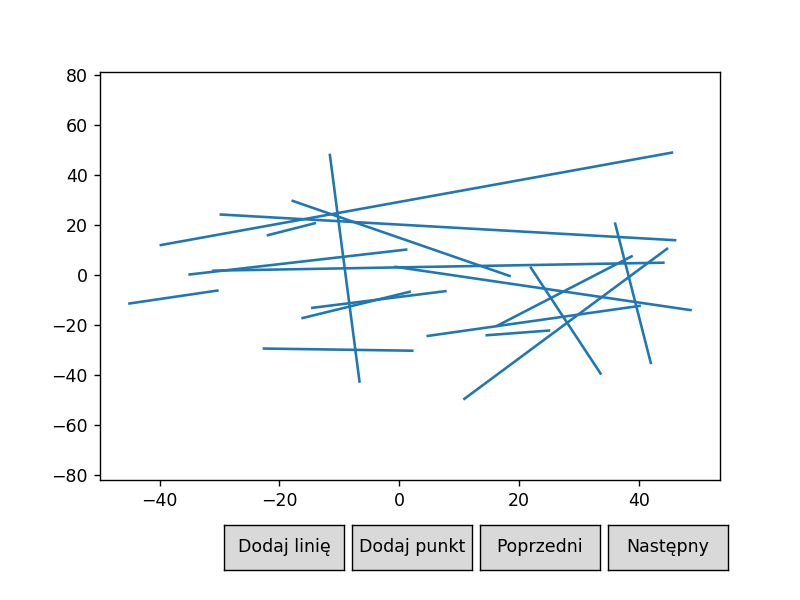

In [35]:
%matplotlib notebook

test3 = [[(18.632999,-0.456000), (-17.973000,29.846001)],
        [(10.711000,-49.713001), (44.897999,10.854000)],
        [(4.558000,-24.339001), (40.367001,-12.191000)],
        [(-13.885000,20.887000), (-22.125000,15.871000)],
        [(25.216999,-22.073000), (14.402000,-24.028999)],
        [(-11.601000,48.555000), (-6.603000,-42.967999)],
        [(42.063999,-35.520000), (36.016998,21.103001)],
         [(48.861000,-14.015000), (-0.831000,3.419000)],
        [(-31.225000,1.808000), (44.335999,5.011000)],
        [(16.204000,-20.398001), (39.001999,7.774000)],
        [(21.882000,3.404000), (33.744999,-39.719002)],
        [(1.959000,-6.506000), (-16.334999,-17.238001)],
        [(-14.729000,-13.104000), (7.925000,-6.312000)],
        [(1.376000,10.294000), (-35.209000,0.238000)],
        [(46.278999,13.960000), (-29.990999,24.277000)],
        [(-30.150999,-6.058000), (-45.257999,-11.376000)],
        [(45.750000,49.078999), (-40.013000,11.954000)],
        [(2.393000,-30.174999), (-22.804001,-29.296000)]]

removeWrongSegments(test3)

intersections, scenes = BentleyOttmannStepByStep(test3)

print("Number of intersections: " + str(len(intersections)))

plot = Plot(scenes)
plot.draw()